In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

import pandas as pd
import datetime as dt

from scipy import stats
import statsmodels.api as sm

C:\Users\Iru\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Читаем данные

In [2]:
df=pd.read_pickle('MG_Sales.pickle',compression='gzip')

## Обучение с помощью прорицателя фейсбука

In [61]:
#Формируем выборку
time_series=pd.DataFrame(data=df[(df['ЦветМеталла']=='Красное золото')&(df['Дата']>=dt.date(2016,1,1))].groupby('Дата')['Количество'].sum())
time_series.index.name='ds'
time_series.columns=['y']
 
#делим выборку на обучающую и валидационную
date_div=dt.date(2017,3,1)
date_div_past=date_div-dt.timedelta(days=1)

time_series_train=time_series.loc[:date_div_past]
time_series_test=time_series.loc[date_div:]

In [62]:
#Обучение
#changepoint_prior_scale - гиперпараметр процента точек смены тренда (по-умолчанию: 0.05)
#changepoints  - массив для ручной установки дат смены тренда
#interval_width - предсказательный интервал
#mcmc_samples - количество шагов для расчета неопределенности в сезонности для байесовской модели
#holidays - датасет с праздниками https://facebookincubator.github.io/prophet/docs/holiday_effects.html
m = Prophet(changepoint_prior_scale=0.03,yearly_seasonality=True)
m.fit(time_series_train.reset_index())

## Валидация

In [63]:
#Подготовка календаря будущего
future = time_series_test.reset_index()

#Предсказание
forecast = m.predict(future)

## Отрисовка

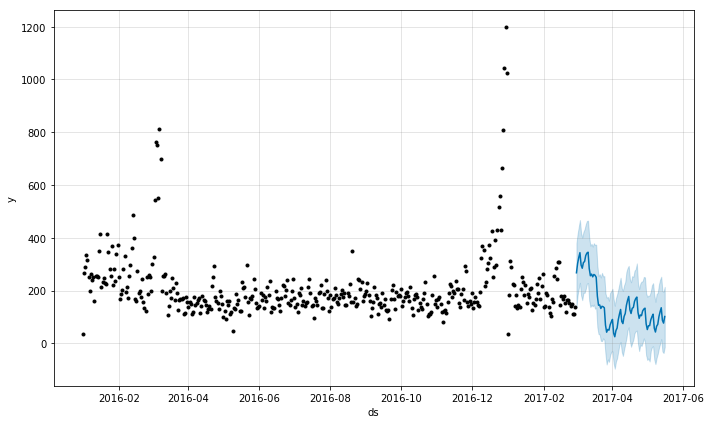

In [64]:
m.plot(forecast)

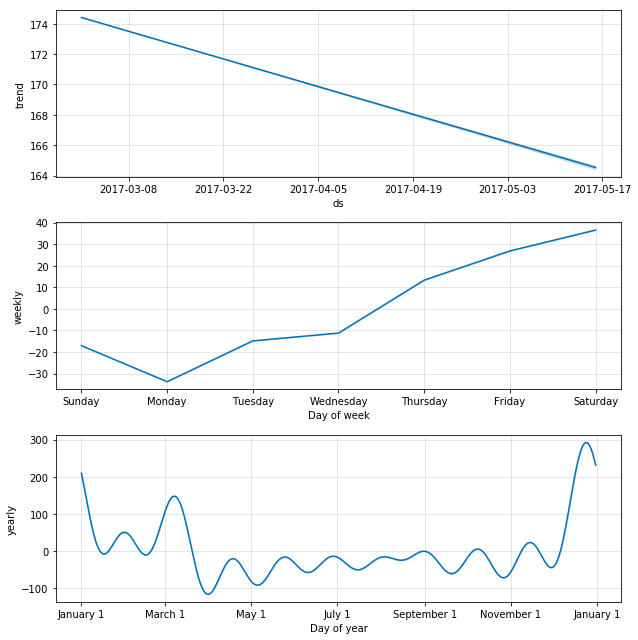

In [65]:
m.plot_components(forecast)

## Оценка качества модели

In [68]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(time_series_test)
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print ('MAPE (Качество, чем ниже тем лучше)', round(np.mean(abs(cmp_df['p'])),2))
print ('MAE (Абсолютное значение ошибки, чем ниже тем лучше)', round(np.mean(abs(cmp_df['e'])),2))
cmp_df.drop(['e','p'],inplace=True, axis=1)

MAPE (Качество, чем ниже тем лучше) 38.53
MAE (Абсолютное значение ошибки, чем ниже тем лучше) 62.59


In [69]:
cmp_df

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-03-01,267.343012,138.391139,379.426286,231
2017-03-02,302.599714,182.894397,415.031706,256
2017-03-03,325.717393,208.012254,441.762596,280
2017-03-04,343.602354,229.483852,467.294668,413
2017-03-05,296.580644,181.209640,417.639514,434
2017-03-06,284.532358,163.473484,400.858655,503
2017-03-07,306.020506,191.428241,422.031730,913
2017-03-08,310.051396,191.290453,432.608272,621
2017-03-09,332.714033,205.640452,450.778839,148
